Credits to the Experts (Please like their kernels)<br>
Ashish Gupta: [20+ top lgbm models outputs](https://www.kaggle.com/roydatascience/lgmodels)<br>
Navaneetha: [xtreme-boost-and-feature-engineering](https://www.kaggle.com/krishonaveen/xtreme-boost-and-feature-engineering)<br>
Shugen: [lgb-starter-r](https://www.kaggle.com/andrew60909/lgb-starter-r) <br>
Khan HBK: [hust-lgb-starter-with-r](https://www.kaggle.com/duykhanh99/hust-lgb-starter-with-r)<br>
Konstantin: [ieee-internal-blend](https://www.kaggle.com/kyakovlev/ieee-internal-blend)<br>
Avocado: [xgb-model-with-feature-engineering](https://www.kaggle.com/iasnobmatsu/xgb-model-with-feature-engineering)<br>
David: [feature-engineering-lightgbm-w-gpu](https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm-w-gpu)<br>
Lyalikov: [lgbm-baseline-small-fe-no-blend](https://www.kaggle.com/timon88/lgbm-baseline-small-fe-no-blend)<br>
Yuanrong: [lgb-xgb-ensemble-stacking-based-on-fea-eng](https://www.kaggle.com/yw6916/lgb-xgb-ensemble-stacking-based-on-fea-eng)<br>


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import rankdata
from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Stacking Approach using GMEAN

In [2]:
LABELS = ["isFraud"]
all_files = glob.glob("../input/lgmodels/*.csv")
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    print(i,all_files[i])
    scores[i] = float(all_files[i].replace('_','-').split("-")[1].replace('.csv',''))

0 ../input/lgmodels/submission-0.9468.csv
1 ../input/lgmodels/submission-.9454.csv
2 ../input/lgmodels/submission-.9451.csv
3 ../input/lgmodels/submission-0.9475.csv
4 ../input/lgmodels/submission-0.9466.csv
5 ../input/lgmodels/submission-.9460.csv
6 ../input/lgmodels/submission-0.9467.csv
7 ../input/lgmodels/Submission-.9440.csv
8 ../input/lgmodels/submission-.9459.csv
9 ../input/lgmodels/Submission-.9429.csv
10 ../input/lgmodels/Submission-.9433.csv
11 ../input/lgmodels/submission_.9452.csv
12 ../input/lgmodels/submission-.9480.csv
13 ../input/lgmodels/submission-.9463.csv
14 ../input/lgmodels/submission-.9408.csv
15 ../input/lgmodels/submission-.9452.csv
16 ../input/lgmodels/Submission-.9442.csv
17 ../input/lgmodels/submission-.9469.csv
18 ../input/lgmodels/submission-.9449.csv
19 ../input/lgmodels/submission-.9485.csv
20 ../input/lgmodels/submission-0.9433.csv
21 ../input/lgmodels/Submission-.9438.csv
22 ../input/lgmodels/submission-.9468.csv
23 ../input/lgmodels/submission-.9457.c

In [3]:
top10 = scores.argsort()[-10:][::-1]
for i, f in enumerate(top10):
    print(i,all_files[f])

print(top10)

0 ../input/lgmodels/submission-.9485.csv
1 ../input/lgmodels/submission-.9480.csv
2 ../input/lgmodels/submission-0.9475.csv
3 ../input/lgmodels/submission-.9469.csv
4 ../input/lgmodels/submission-0.9468.csv
5 ../input/lgmodels/submission-.9468.csv
6 ../input/lgmodels/submission-0.9467.csv
7 ../input/lgmodels/submission-0.9466.csv
8 ../input/lgmodels/submission-.9463.csv
9 ../input/lgmodels/submission-.9460.csv
[19 12  3 17  0 22  6  4 13  5]


In [4]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top10]
outs.append(pd.read_csv("../input/ensemble-9485/submission (1).csv",index_col=0))

concat_sub = pd.concat(outs, axis=1)

cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)

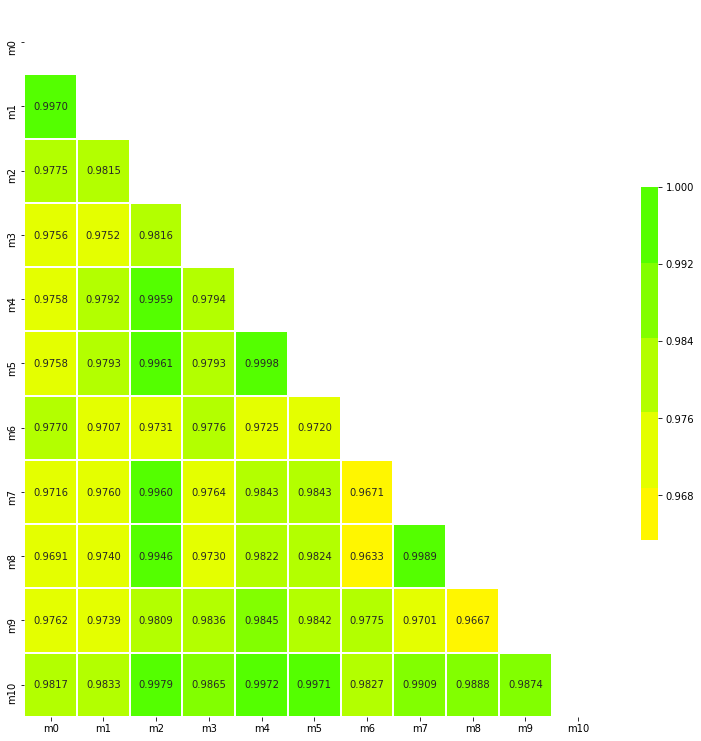

In [5]:
# check correlation
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Weighted GMEAN by inverse correlation

In [6]:
rank = np.tril(concat_sub.iloc[:,1:].corr().values,-1)
m = (rank>0).sum() - (rank>0.99).sum()
m_gmean, s = 0, 0
for n in range(min(rank.shape[0],m)):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/(m+n/8)
    m_gmean += w*(np.log(concat_sub.iloc[:,mx[0]+1])+np.log(concat_sub.iloc[:,mx[1]+1]))/2
    s += w
    rank[mx] = 1
m_gmean = np.exp(m_gmean/s)

In [7]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(0.0, 1.0), mean=0.024361973188344755, variance=0.012834405985087656, skewness=7.123975788227058, kurtosis=52.22414048270187)

In [8]:
concat_sub['isFraud'] = m_gmean
concat_sub[['TransactionID','isFraud']].to_csv('stack_gmean.csv',index=False)

In [9]:
sub_9518 = pd.read_csv("../input/sub-9518/sub_09518.csv")
concat_sub["isFraud"] += sub_9518["isFraud"]

In [10]:
concat_sub[['TransactionID','isFraud']].to_csv('blend.csv',index=False)